# Will You Accept This Analysis?
#### Danielle Eliav
Since 2002, millions of viewers tune in to watch what Chris Harrison promises will be "the most dramatic season" of The Bachelor(ette) yet. From jumping fences to fist fights to lots and lots of tears every season brings new drama to TVs all over the country. 

For those unfamiliar with The Bachelor franchise, the main shows, The Bachelor and The Bachelorette, feature a male or female lead, the bachelor or bachelorette respectively, looking for true love. Every season begins with 20-30 suitors arriving to compete for the attention and affection of the bachelor(ette). The first night, the bachelor(ette) gives out one (or occasionally many) first impression rose, allowing them to remain on the show for the second week, to the contestant(s) he/she feels made the best first impression. Every subsequent week, the lead goes on a few dates with one or a group of the contestants and gives out roses that represent them being chosen to remain on the show for another week. By the series finale, there are only two suitors remaining: one leaves heartbroken, the other leaves engaged to the lead and the two eventually get married.

At least that's the hope. In reality couples from the show rarely stay together long term and the authenticity of the show has been questioned on more than one occasion. Even so, the franchise continues to thrive with almost 40 seasons between The Bachelor and The Bachelorette as of when this was written. Needless to say, the show has amassed a dedicated following, referred to as "Bachelor Nation", and has inspired many to compete in leagues akin to those of fantasy football trying to create brackets that predict the outcome of every season. 


In this tutorial, we'll examine the success rate of the show and its relation to first impressions roses and the age of contestants. We'll also look at whether first impression roses are good predictors of the final two. 

## Data Collection

The first step is to collect the necessary data. We'll be collecting our data from Wikipedia. We'll collect the names and ages of each contestant and note their sex and which season they're from. We'll also collect the names of the winner and runner-up(s) of each season as well as whether the couple from that season got engaged and if they're still together.
Let's start with the information on the contestants. 

In [98]:
import re
import time
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

def remove_footnotes(s):
    end = s.find('[')
    if end != -1:
        return s[:end]
    else:
        return s

def scrape_contestants(base_url, seasons, sex):

    result= []
        
    for i in range(1,seasons+1):
        current_url = base_url + str(i) + ')'
        print('checking {}'.format(current_url))
        response = requests.get(current_url)
        soup = BeautifulSoup(response.text, 'html.parser')
    
        if sex == 'M' and (i == 2 or i ==3): #two seasons of The Bachelorette have pages that are structured differently 
            contestants = soup.find('table',{'class':'wikitable'})
        else:
            contestants= soup.find('table',{'class':'wikitable sortable'})
                
        if contestants != None:
            contestants = contestants.find_all('tr')

            for contestant in contestants[1:]:
                contestant = contestant.find_all('td')
                
                result.append({
                    'name': remove_footnotes(contestant[0].text.strip()),
                    'age': remove_footnotes(contestant[1].text.strip()),
                    'sex': sex,
                    'season': i
                })
    
    return pd.DataFrame(result)

bachelor_URL = 'https://en.wikipedia.org/wiki/The_Bachelor_(American_season_'
bachelorette_URL   = 'https://en.wikipedia.org/wiki/The_Bachelorette_(season_'

# Data loaded from CSV to save time
# bachelor_contestants = scrape_contestants(bachelor_URL, 24, 'F')
# bachelorette_contestants = scrape_contestants(bachelorette_URL, 15, 'M')
# bachelor_contestants.to_csv('csv/bachelor_contestants.csv')
# bachelorette_contestants.to_csv('csv/bachelorette_contestants.csv')

bachelor_contestants = pd.read_csv('csv/bachelor_contestants.csv')
bachelorette_contestants = pd.read_csv('csv/bachelorette_contestants.csv')

contestants = pd.concat([bachelor_contestants, bachelorette_contestants], ignore_index=True).drop('Unnamed: 0', axis=1)
contestants.sample(5)

,name,age,sex,season
824,"Matthew ""Matt"" Munson",32.0,M,13
757,Ron Worrell,28.0,M,10
480,Revian Chang,24.0,F,23
828,Anthony Battle,26.0,M,13
369,Becca Tilley,26.0,F,20


Now we have a pandas dataframe with the name, age, sex, and season of almost every contestant from The Bachelor and The Bachelorette. Seasons 3,4,6,7, and 8 of The Bachelor do not have contestant data available on Wikipedia, but we do have data from the remaining 33 seasons that have finished airing. 

Next we'll scrape the outcomes of each season. 

In [99]:
def scrape_seasons(URL, sex):
    response = requests.get(URL)
    soup = BeautifulSoup(response.text, 'html.parser')

    seasons= soup.find('table',{'class':'wikitable plainrowheaders'})
    result = []
    if seasons != None:
        seasons = seasons.find_all('tr')

        i = 1
        for season in seasons[1:]:
            season = season.find_all(['td','th'])

            if len(season) == 8 and not (sex == 'F' and i == 16 ): #season 16 of The Bachelorette is still airing

                
                result.append({
                    'sex' : sex,
                    'season': i,
                    'lead': remove_footnotes(season[2].text.strip()),
                    'winner': remove_footnotes(season[3].text.strip()),
                    'runner-up': remove_footnotes(season[4].text.strip()),
                    'engagement': (remove_footnotes(season[5].text.strip()) == 'Yes'),
                    'still_together': (remove_footnotes(season[6].text.strip()) == 'Yes')
                })
                i += 1
                
            else:
                if (sex == 'M' and  i < 25): #seasons that had two runner-ups (season 25 of The Bachelor hasn't aired yet)
                     result[i-2]['runner-up'] += ',' + remove_footnotes(season[0].text.strip())
                if (sex == 'F' and i == 11): #season 11 of The Bachelorette had the same runner-up as season 10
                    result.append({
                        'sex' : sex,
                        'season': i,
                        'lead': remove_footnotes(season[2].text.strip()),
                        'winner': remove_footnotes(season[3].text.strip()),
                        'runner-up': result[i-2]['runner-up'],
                        'engagement': (remove_footnotes(season[5].text.strip()) == 'Yes'),
                        'still_together': (remove_footnotes(season[6].text.strip()) == 'Yes')
                    })
                    i += 1

    return pd.DataFrame(result)

# Data loaded from csv to save time
# bachelor_seasons = scrape_seasons('https://en.wikipedia.org/wiki/The_Bachelor_(American_TV_series)', 'M')
# bachelor_seasons.to_csv('csv/bachelor_seasons.csv')

# bachelorette_seasons = scrape_seasons('https://en.wikipedia.org/wiki/The_Bachelorette', 'F')
# bachelorette_seasons.to_csv('csv/bachelorette_seasons.csv')

bachelor_seasons = pd.read_csv('csv/bachelor_seasons.csv')
bachelorette_seasons = pd.read_csv('csv/bachelorette_seasons.csv')

seasons = pd.concat([bachelor_seasons, bachelorette_seasons], ignore_index=True).drop('Unnamed: 0', axis=1)
seasons.sample(5)

,sex,season,lead,winner,runner-up,engagement,still_together
15,M,16,Ben Flajnik,Courtney Robertson,Lindzi Cox,True,False
36,F,13,Rachel Lindsay,Bryan Abasolo,Peter Kraus,True,True
16,M,17,Sean Lowe,Catherine Giudici,Lindsay Yenter,True,True
32,F,9,Desiree Hartsock,Chris Siegfried,Drew Kenney,True,True
30,F,7,Ashley Hebert,J.P. Rosenbaum,Ben Flajnik,True,False


Now we also have a dataframe with the name and sex of the lead of each season, the names of their winner and runner-up(s), if the couple left engaged, and if they're still together.

Lucky for us the data is already clean so we can just right in to analysis and see what we find!

## Data Analysis and Visualization
Let's start by looking at the number of seasons compared to the number of engagements and successful couples. To do this, we'll create a stacked bar graph using matplotlib with a bar for each show and the two combined.

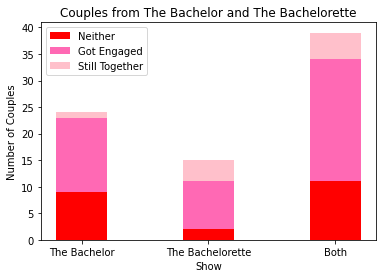

In [100]:
import matplotlib.pyplot as plt

N = 3

bachelor_seasons = seasons[seasons['sex'] == 'M']
num_seasons = (bachelor_seasons.sex.count())
num_engaged = bachelor_seasons[bachelor_seasons['engagement']].sex.count()
num_together = bachelor_seasons[bachelor_seasons['still_together']].sex.count()

bachelorette_seasons = seasons[seasons['sex'] == 'F']
num_seasons2 = (bachelorette_seasons.sex.count())
num_engaged2 = bachelorette_seasons[bachelorette_seasons['engagement']].sex.count()
num_together2 = bachelorette_seasons[bachelorette_seasons['still_together']].sex.count()

neither = ((num_seasons - num_engaged), (num_seasons2 - num_engaged2), (num_seasons - num_engaged) + (num_seasons2 - num_engaged2))
engaged = ((num_engaged - num_together), (num_engaged2 - num_together2), ((num_engaged - num_together) + (num_engaged2 - num_together2)))
together = (num_together, num_together2, num_together + num_together2 )

ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, neither, width, color = 'red')
p2 = plt.bar(ind, engaged, width, bottom=neither, color = 'hotpink')
p3 = plt.bar(ind, together, width, bottom=(num_seasons - num_together, num_seasons2 - num_together2, (num_seasons - num_together + num_seasons2 - num_together2)), color = 'pink')

plt.ylabel('Number of Couples')
plt.xlabel('Show')
plt.title('Couples from The Bachelor and The Bachelorette')
plt.xticks(ind, ('The Bachelor', 'The Bachelorette', 'Both'))
plt.yticks(np.arange(0, 45, 5))
plt.legend((p1[0], p2[0], p3[0]), ('Neither', 'Got Engaged', 'Still Together'))

plt.show()

Based on our graph, it's clear that not many couples from the franchise stay together. Although a lot of seasons end in an engagement, those rarely last.
This graph gives us some insight into the success rates, but a graph showing the percentages would probably be more helpful. Luckily that's an easy adjustment.

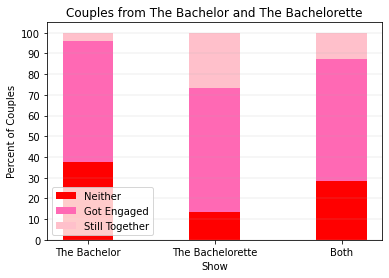

In [101]:
from operator import mul 
from operator import add

N = 3

bachelor_seasons = seasons[seasons['sex'] == 'M']
num_seasons = (bachelor_seasons.sex.count())
num_engaged = bachelor_seasons[bachelor_seasons['engagement']].sex.count()
num_together = bachelor_seasons[bachelor_seasons['still_together']].sex.count()

bachelorette_seasons = seasons[seasons['sex'] == 'F']
num_seasons2 = (bachelorette_seasons.sex.count())
num_engaged2 = bachelorette_seasons[bachelorette_seasons['engagement']].sex.count()
num_together2 = bachelorette_seasons[bachelorette_seasons['still_together']].sex.count()

neither = ((num_seasons - num_engaged), (num_seasons2 - num_engaged2), (num_seasons - num_engaged) + (num_seasons2 - num_engaged2))
engaged = ((num_engaged - num_together), (num_engaged2 - num_together2), ((num_engaged - num_together) + (num_engaged2 - num_together2)))
together = (num_together, num_together2, num_together + num_together2)

to_percent = (100/num_seasons, 100/num_seasons2, 100/(num_seasons + num_seasons2))

pneither = tuple(map(mul, neither, to_percent))
pengaged = tuple(map(mul, engaged, to_percent))
ptogether = tuple(map(mul, together, to_percent))


ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pneither, width, color = 'red')
p2 = plt.bar(ind, pengaged, width, bottom=pneither, color = 'hotpink')
p3 = plt.bar(ind, ptogether, width, bottom=tuple(map(add, pengaged, pneither)), color = 'pink')

plt.ylabel('Percent of Couples')
plt.xlabel('Show')
plt.title('Couples from The Bachelor and The Bachelorette')
plt.xticks(ind, ('The Bachelor', 'The Bachelorette', 'Both'))
plt.yticks(np.arange(0, 101, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Neither', 'Got Engaged', 'Still Together'))
plt.grid(b=True, axis='y', lw=.2)
plt.show()

Now we can clearly see that almost 30% of couples from The Bachelorette stay together while less than 5% of couples from The Bachelor stay together. Across both shows, 70% of seasons end with an engagement but only 10% of couples stay together. 

Many in Bachelor Nation complain at the young age of the contestants in some seasons. Let's look at the average age of contestants through the seasons and see if it's correlated to whether or not the couple is successful.

Let's start with a line graph of the average age of contestants throughout the seasons of the shows. Since our previous graph showed drastically different data between the two shows, we'll continue to split them up.

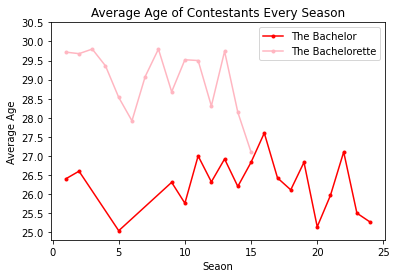

In [102]:
grouped = contestants.groupby(by=['sex','season']).mean().reset_index()

x = grouped[grouped['sex'] == 'F'].season
y = grouped[grouped['sex'] == 'F'].age

plt.plot(x,y, label='The Bachelor', color='red', marker='.')

x = grouped[grouped['sex'] == 'M'].season
y = grouped[grouped['sex'] == 'M'].age

plt.plot(x,y,label='The Bachelorette',color='lightpink', marker='.')
plt.yticks(np.arange(25, 31, .5))
plt.ylabel('Average Age')
plt.xlabel('Seaon')
plt.title('Average Age of Contestants Every Season')
plt.legend()


It looks like contestants on The Bachelorette tend to be older than those on the The Bachelor and there has been a downward trend in recent seasons. I wonder if the older age of the contestants on The Bachelorette is related to the success rate of the show. Let's take a closer look at the distribution of ages on the two shows on successful seasons vs. unsuccessful seasons. 

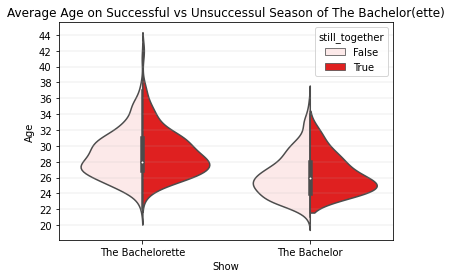

In [120]:
import seaborn as sns

# seasons['sex'] = seasons['sex'] == 'M'
# contestants['sex'] = (contestants['sex'] == 'F')
# merged = contestants.merge(seasons, how='left', on = ['sex', 'season'])
plot = sns.violinplot(x='sex', y="age", hue="still_together",data=merged, split=True, color='red')
plot.set_title('Average Age on Successful vs Unsuccessul Season of The Bachelor(ette)')
plot.set_ylabel('Age')
plot.set_xlabel('Show')
plot.set_xticklabels(['The Bachelorette', 'The Bachelor'])
plt.yticks(np.arange(20, 45, 2))
plt.grid(b=True, axis='y', lw=.2)


In [80]:
name = seasons['winner'].str.split(" ",n=2, expand = True)
seasons['winner_first'] = name[0]
seasons['winner_lasti'] = name[1].str[0] +'.'

name = seasons['runner-up'].str.split(" ", expand = True)
seasons['second_first'] = name[0]
seasons['second_lasti'] = name[1].str[0] + '.'

seasons.at[20, 'second_first'] = 'Jojo'
seasons.at[20, 'second_lasti'] = 'F.'
seasons.at[25, 'winner_lasti'] = 'Ann'



In [317]:
def scrape_roses(df):
    bachelor_URL = 'https://en.wikipedia.org/wiki/The_Bachelor_(American_season_'
    bachelorette_URL   = 'https://en.wikipedia.org/wiki/The_Bachelorette_(season_'
    w_first = [] #if the winner recieved a first impression rose 
    ru_first = [] #if the runner-up recieved a first impression rose
    
    for i,row in df.iterrows():
        if row['sex'] == 'M':
            url = bachelor_URL
        else:
            url = bachelorette_URL
        
        url += str(row['season']) + ')'
        
#         print('checking {}'.format(url))
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
    
        roses = soup.find(id=["Elimination_Chart","Call-Out_Order", "Call-out_order"])
       
        if roses != None:
            roses = roses.find_parent().find_next_sibling('table')
            roses = roses.find_all('tr')[2:]
            
            name = roses[0].find_all('td')[1].text.strip().split(' ', 2)
            
            if name[0] == row['winner_first'] and (len(name) == 1 or name[1] == row['winner_lasti']):
                w_first.append(True)
            elif name[0] == row['second_first'] and (len(name) == 1 or name[1] == row['second_lasti']):
                ru_first.append(True)
            
            j = 1
            while ('skyblue' in str(roses[j].find_all('td')[1].attrs) or 'orange' in str(roses[j].find_all('td')[1].attrs) ):
                name = roses[j].find_all('td')[1].text.strip().split(' ', 2)
                if name[0] == row['winner_first'] and (len(name) == 1 or name[1] == row['winner_lasti']):
                    w_first.append(True)
                elif name[0] == row['second_first'] and (len(name) == 1 or name[1] == row['second_lasti']):
                    ru_first.append(True)
                j += 1
            
            if len(w_first) != i+1:
                w_first.append(False)
            if len(ru_first) != i+1:
                ru_first.append(False)
    df['winner_fi'] = w_first
    df['second_fi'] = ru_first
        
    return df

# seasons = seasons.drop(2).drop(3).drop(5).drop(6).drop(7).reset_index(drop = True)

# roses = scrape_roses(seasons)
# roses.to_csv('csv/roses.csv')

roses = pd.read_csv('csv/roses.csv').drop('Unnamed: 0', axis=1)
